# Chapter 3: Classification

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

In [5]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X.shape, y.shape)

(70000, 784) (70000,)


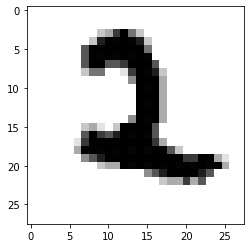

In [7]:
plt.imshow(X[np.random.randint(0, 70000)].reshape(28, 28), cmap='binary')

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    precision_recall_curve,
    roc_curve
)

This step below is kind of interesting. We're using cross validation on training set to get untainted predictions since `cross_val_predict` is splitting into test/train sets on CV folds. 

In [9]:
clf = SGDClassifier(random_state=42)

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=3)

### Precision/Recall Trade-Off

In [10]:
print(confusion_matrix(y_train_5, y_train_pred))
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))
print("F1:", f1_score(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]
Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1: 0.7325171197343846


In [11]:
y_scores = cross_val_predict(clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [12]:
prec, rec, thresh = precision_recall_curve(y_train_5, y_scores)

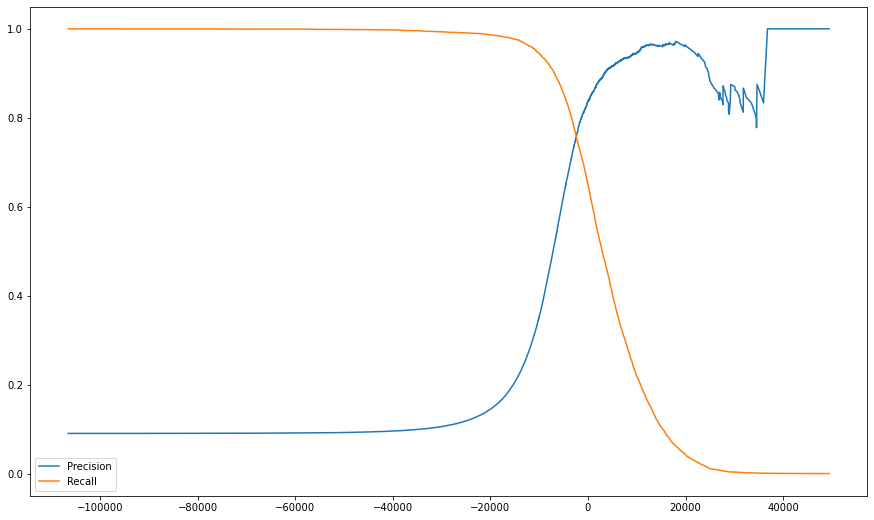

In [13]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(thresh, prec[:-1], label="Precision", ax=ax)
sns.lineplot(thresh, rec[:-1], label="Recall", ax=ax)

In [14]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

### The ROC Curve
Receiver operating characteristic. Plots true positive rate against false positive rate.

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    sns.lineplot(fpr, tpr, label=label)
    sns.lineplot([0, 1], [0, 1])

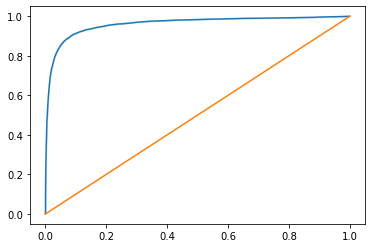

In [17]:
plot_roc_curve(fpr, tpr)

In [18]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

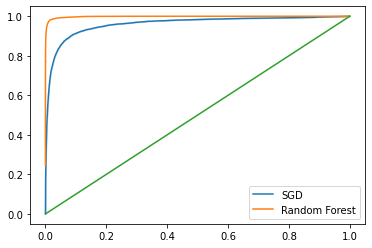

In [21]:
sns.lineplot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

## Multiclass Classification

### p1: Obtain high accuracy on MNIST
Will use `KNeighborsClassifier` as mentioned in the text.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [13]:
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

In [16]:
clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9621, 0.962 , 0.9645])

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [26]:
from sklearn.model_selection import GridSearchCV

In [63]:
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [5]}
]

In [15]:
clf = KNeighborsClassifier(n_jobs=-1)
grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

NameError: name 'GridSearchCV' is not defined

In [65]:
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')

In [66]:
final_clf = grid_search.best_estimator_
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [67]:
y_hat_test = final_clf.predict(X_test_scaled)

In [68]:
confusion_matrix(y_hat_test, y_test)

array([[ 963,    0,   13,    0,    1,    4,   10,    0,   12,    5],
       [   0, 1128,    5,    2,    9,    0,    4,   20,    2,    5],
       [   0,    3,  958,    4,    5,    2,    2,   12,    5,    5],
       [   4,    1,   20,  962,    2,   21,    0,    4,   17,   10],
       [   0,    0,    5,    2,  921,    8,    3,    6,    8,   17],
       [   6,    0,    0,   13,    2,  825,    6,    2,   28,    4],
       [   6,    3,    7,    1,    7,   13,  930,    0,    4,    0],
       [   1,    0,   12,   11,    4,    2,    0,  950,    6,   30],
       [   0,    0,   10,    9,    3,    8,    3,    1,  884,    4],
       [   0,    0,    2,    6,   28,    9,    0,   33,    8,  929]])

In [69]:
precision_score(y_hat_test, y_test, average='macro')

0.9443233317556862

In [72]:
accuracy_score(y_hat_test, y_test)

0.945

In [82]:
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=1, weights='distance')

In [83]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='distance')

In [84]:
y_hat = clf.predict(X_test)

In [85]:
accuracy_score(y_hat, y_test)

0.9691